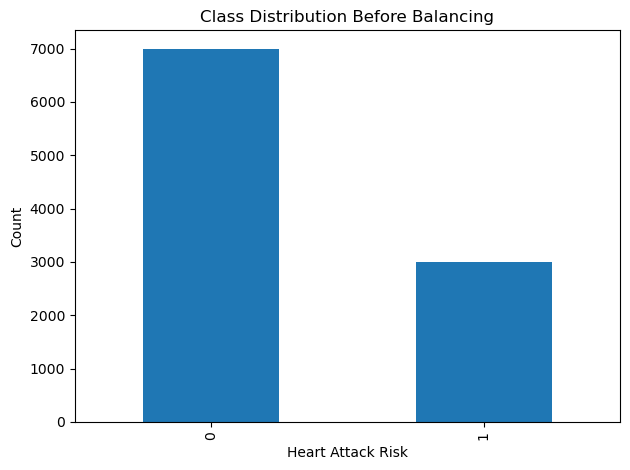

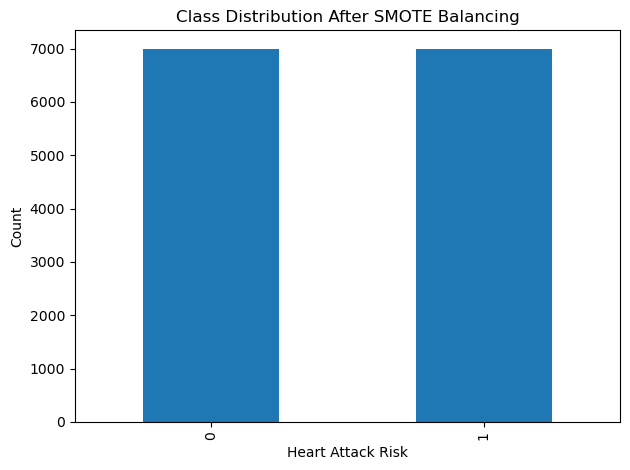

Original Dataset Shape : (10000, 24)
Balanced Dataset Shape : (13986, 24)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------------
# Load Dataset
# --------------------------------------------------
df = pd.read_excel("heart_attack_prediction_india.xlsx")

# --------------------------------------------------
# Drop non-useful columns
# --------------------------------------------------
df = df.drop(columns=["Patient_ID", "State_Name"])

# --------------------------------------------------
# Encode categorical column
# --------------------------------------------------
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])

# --------------------------------------------------
# Separate features and target
# --------------------------------------------------
X = df.drop(columns=["Heart_Attack_Risk"])
y = df["Heart_Attack_Risk"]

# --------------------------------------------------
# BEFORE Balancing Plot
# --------------------------------------------------
plt.figure()
y.value_counts().plot(kind="bar")
plt.title("Class Distribution Before Balancing")
plt.xlabel("Heart Attack Risk")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("Indian_class_distribution_before_balancing.png", dpi=300)
plt.show()

# --------------------------------------------------
# Apply SMOTE
# --------------------------------------------------
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# --------------------------------------------------
# AFTER Balancing Plot
# --------------------------------------------------
plt.figure()
pd.Series(y_balanced).value_counts().plot(kind="bar")
plt.title("Class Distribution After SMOTE Balancing")
plt.xlabel("Heart Attack Risk")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("Indian_class_distribution_after_balancing.png", dpi=300)
plt.show()

# --------------------------------------------------
# Final Balanced Dataset
# --------------------------------------------------
balanced_df = pd.concat(
    [pd.DataFrame(X_balanced, columns=X.columns),
     pd.Series(y_balanced, name="Heart_Attack_Risk")],
    axis=1
)

print("Original Dataset Shape :", df.shape)
print("Balanced Dataset Shape :", balanced_df.shape)


Automatically detected continuous features:
['Age', 'Diet_Score', 'Cholesterol_Level', 'Triglyceride_Level', 'LDL_Level', 'HDL_Level', 'Systolic_BP', 'Diastolic_BP', 'Emergency_Response_Time', 'Annual_Income']

--- Fold 1 ---


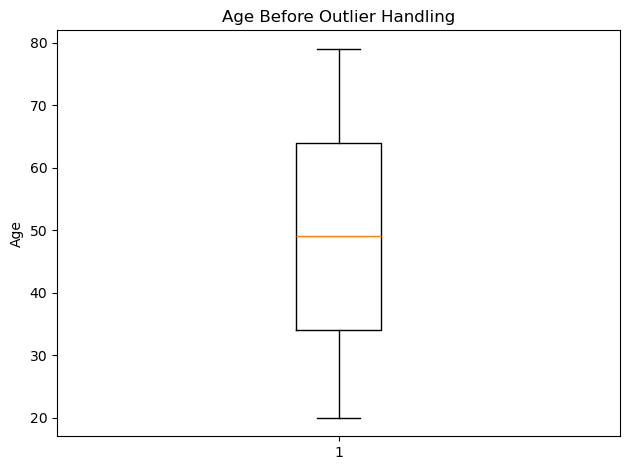

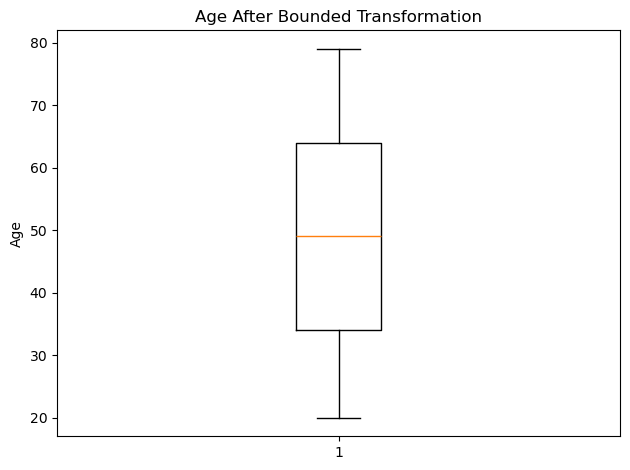

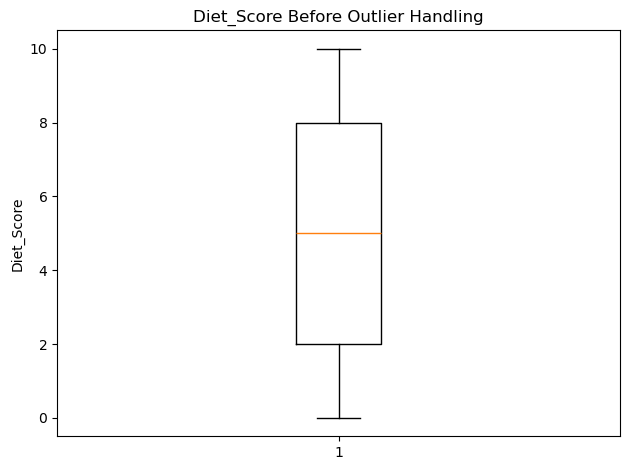

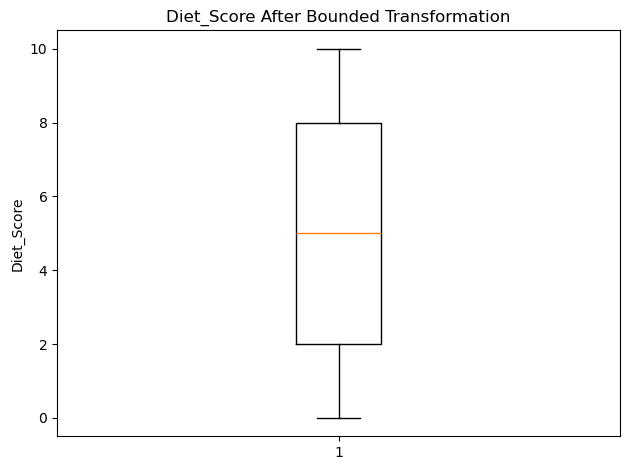

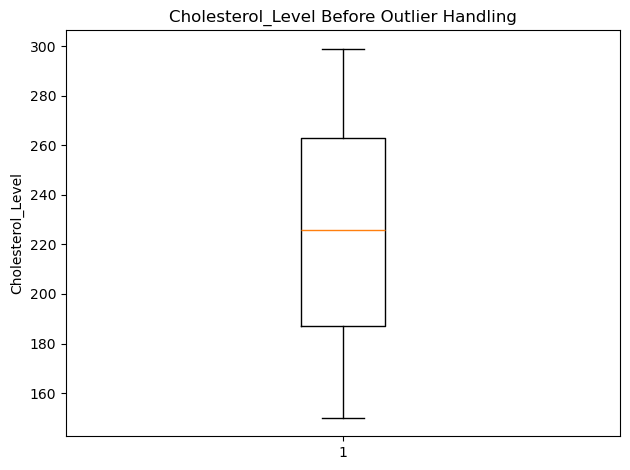

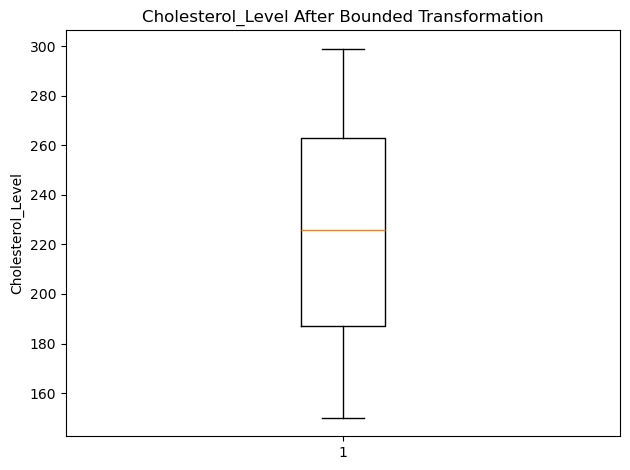

Outlier plots saved successfully.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------------
# Load Dataset
# --------------------------------------------------
df = pd.read_excel("heart_attack_prediction_india.xlsx")

# --------------------------------------------------
# Drop non-informative columns
# --------------------------------------------------
df = df.drop(columns=["Patient_ID", "State_Name"])

# --------------------------------------------------
# Encode categorical columns automatically
# --------------------------------------------------
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# --------------------------------------------------
# Separate features and target
# --------------------------------------------------
X = df.drop(columns=["Heart_Attack_Risk"])
y = df["Heart_Attack_Risk"]

# --------------------------------------------------
# Automatically detect continuous features
# (numeric + sufficient variability)
# --------------------------------------------------
continuous_features = [
    col for col in X.columns
    if X[col].dtype in ["int64", "float64"] and X[col].nunique() > 10
]

print("Automatically detected continuous features:")
print(continuous_features)

# --------------------------------------------------
# IQR-based bounded transformation functions
# --------------------------------------------------
def fit_iqr_bounds(X, features):
    bounds = {}
    for col in features:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return bounds

def apply_iqr_capping(X, bounds):
    X_new = X.copy()
    for col, (low, high) in bounds.items():
        X_new[col] = np.clip(X_new[col], low, high)
    return X_new

# --------------------------------------------------
# Stratified Cross-Validation (Leakage-Safe)
# --------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

    # ---- Fit outlier bounds ONLY on training data ----
    iqr_bounds = fit_iqr_bounds(X_train, continuous_features)

    # ---- Apply bounded transformation ----
    X_train_capped = apply_iqr_capping(X_train, iqr_bounds)
    X_test_capped = apply_iqr_capping(X_test, iqr_bounds)

    # --------------------------------------------------
    # Outlier visualization (ONLY once, for paper)
    # --------------------------------------------------
    if fold == 1:
        for feature in continuous_features[:3]:  
            # plotting first 3 continuous features is enough for paper

            # BEFORE outlier handling
            plt.figure()
            plt.boxplot(X_train[feature])
            plt.title(f"{feature} Before Outlier Handling")
            plt.ylabel(feature)
            plt.tight_layout()
            plt.savefig(f"{feature}_before_outliers.png", dpi=300)
            plt.show()

            # AFTER outlier handling
            plt.figure()
            plt.boxplot(X_train_capped[feature])
            plt.title(f"{feature} After Bounded Transformation")
            plt.ylabel(feature)
            plt.tight_layout()
            plt.savefig(f"{feature}_after_outliers.png", dpi=300)
            plt.show()

        print("Outlier plots saved successfully.")

    break  # plots only needed once


In [15]:
df.isnull().sum()

Age                        0
Gender                     0
Diabetes                   0
Hypertension               0
Obesity                    0
Smoking                    0
Alcohol_Consumption        0
Physical_Activity          0
Diet_Score                 0
Cholesterol_Level          0
Triglyceride_Level         0
LDL_Level                  0
HDL_Level                  0
Systolic_BP                0
Diastolic_BP               0
Air_Pollution_Exposure     0
Family_History             0
Stress_Level               0
Healthcare_Access          0
Heart_Attack_History       0
Emergency_Response_Time    0
Annual_Income              0
Health_Insurance           0
Heart_Attack_Risk          0
dtype: int64